# Proyecto #1
### Yosef Maldonado - 14003689

In [103]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as SKLinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# loading dataset
'''
SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
OverallQual: Overall material and finish quality, rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
       
1stFlrSF: First Floor square feet
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
YearBuilt: Original construction date
LotFrontage: Linear feet of street connected to property
'''

dataset = np.load('./data/proyecto_training_data.npy')

In [3]:
# creating dataframe to label columns
column_labels = ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage']
df = pd.DataFrame(dataset, columns=column_labels)

In [89]:
# slicing dataset
df_rows = df.shape[0]
split_index = int(df_rows * 0.80)  # check where to split
df_training_set = df.iloc[:split_index] # 80% of the data
df_validation_and_test_set = df.iloc[split_index:] # 20% of the data

# Análisis exploratorio de datos (Training set)

In [5]:
# training (80% of dataset) analysis
# DataFrame.describe(): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe
# Transpose (T): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html
df_training_statistics = df_training_set.describe().T 
df_training_statistics['range'] = df_training_statistics['max'] - df_training_statistics['min'] # range
df_training_statistics = df_training_statistics[['mean', 'max', 'min', 'range', 'std']]
df_training_statistics

,mean,max,min,range,std
SalePrice,180590.277397,755000.0,34900.0,720100.0,78815.697902
OverallQual,6.101027,10.0,1.0,9.0,1.378025
1stFlrSF,1156.323630,3228.0,334.0,2894.0,373.780374
TotRmsAbvGrd,6.485445,14.0,2.0,12.0,1.609141
YearBuilt,1971.451199,2010.0,1875.0,135.0,29.951707
LotFrontage,69.946985,313.0,21.0,292.0,23.478161


# Histograma de variable (Training set)

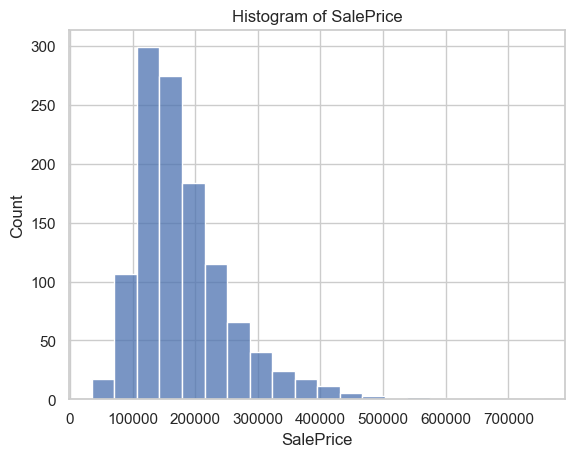

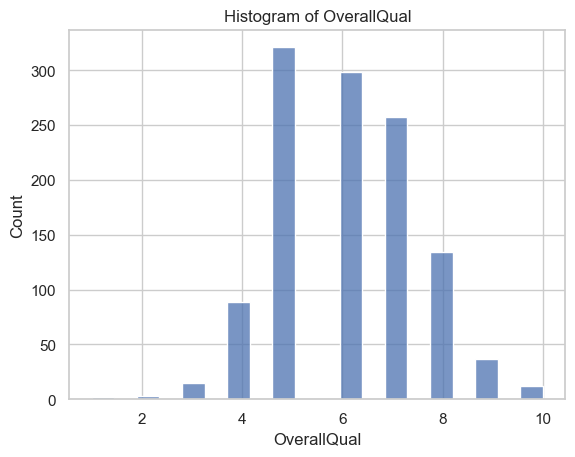

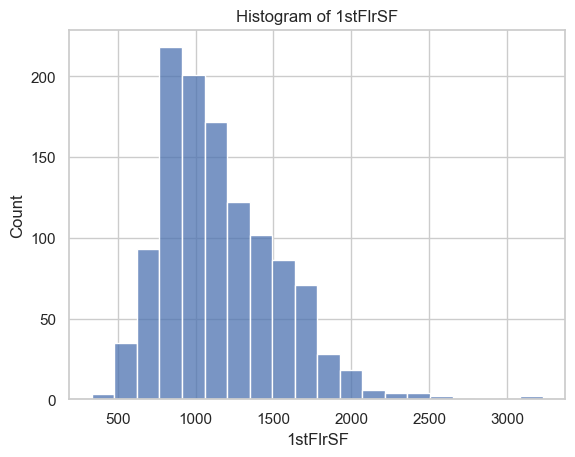

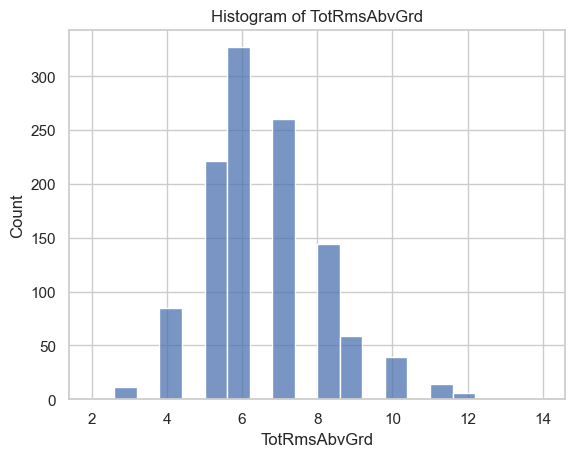

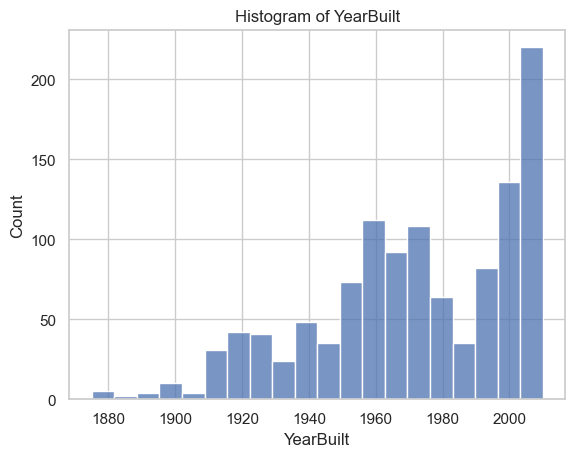

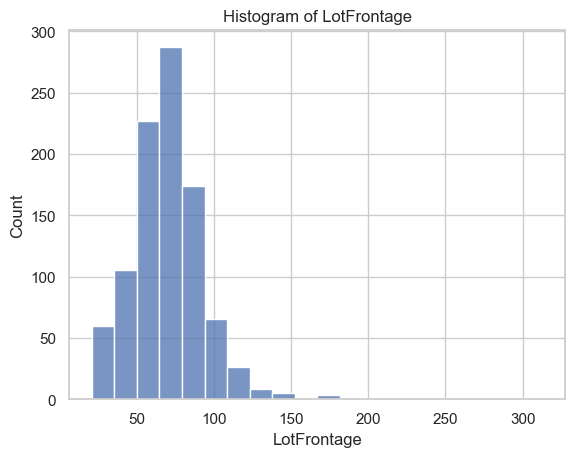

In [6]:
# distplot is deprecated: https://seaborn.pydata.org/generated/seaborn.distplot.html
# using histplot

sns.set(style='whitegrid')

for column in df_training_set.columns:
    sns.histplot(df_training_set[column].dropna(), kde=False, bins=20)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()


# Correlación con variables independientes (Training set)

In [7]:
# SalePrice: "This is the target variable that you're trying to predict" (Dependant variable)

# getting correlations
df_training_correlation_matrix = df_training_set.corr()
df_training_correlation_matrix = df_training_correlation_matrix['SalePrice'].drop('SalePrice')

# convert series to data frame for easier manipulation
df_training_correlation = pd.DataFrame(df_training_correlation_matrix).reset_index()
df_training_correlation.columns = ['Variable', 'Correlation with SalePrice']

# sort by the absolute value of the correlation, descending order (creating temporal column)
df_training_correlation['Absolute Correlation'] = df_training_correlation['Correlation with SalePrice'].abs()
df_training_correlation = df_training_correlation.sort_values(by='Absolute Correlation', ascending=False).drop('Absolute Correlation', axis=1) # removing temporary column

# format the correlation values for better readability
df_training_correlation['Correlation with SalePrice'] = df_training_correlation['Correlation with SalePrice'].apply(lambda x: f'{x:.3f}')

# display the sorted and formatted data frame
df_training_correlation

,Variable,Correlation with SalePrice
0,OverallQual,0.794
1,1stFlrSF,0.616
2,TotRmsAbvGrd,0.565
3,YearBuilt,0.534
4,LotFrontage,0.363


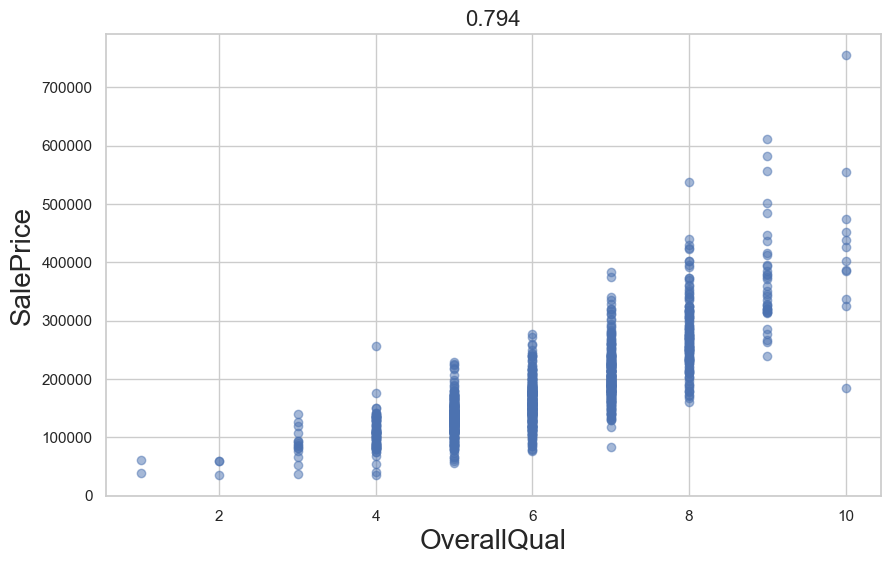

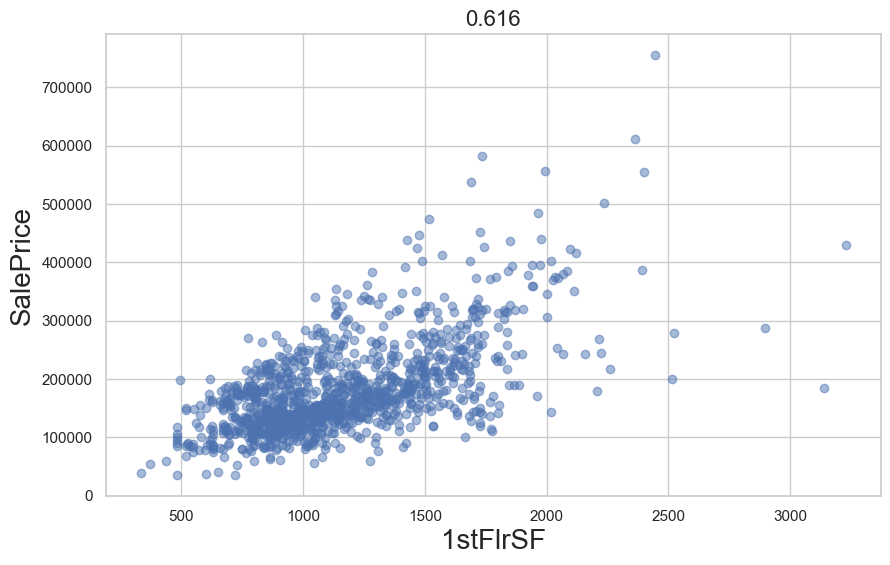

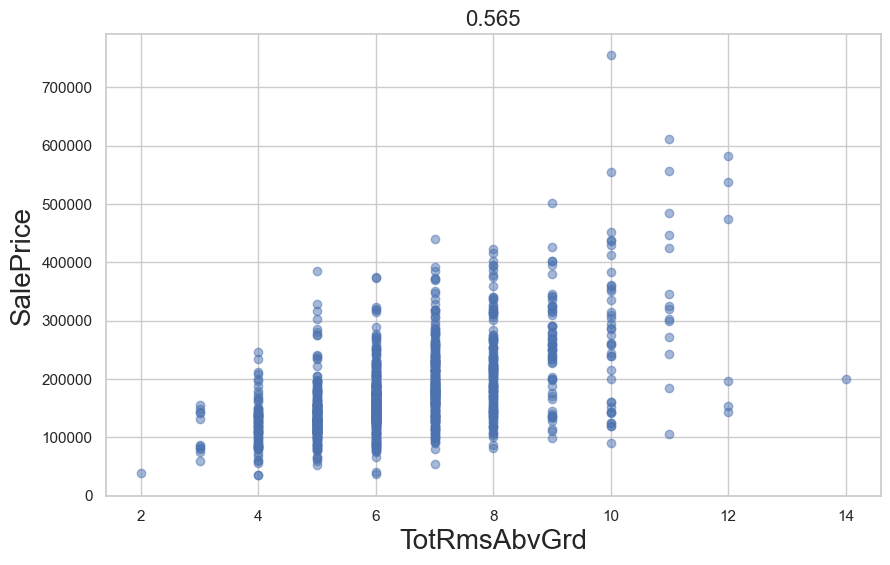

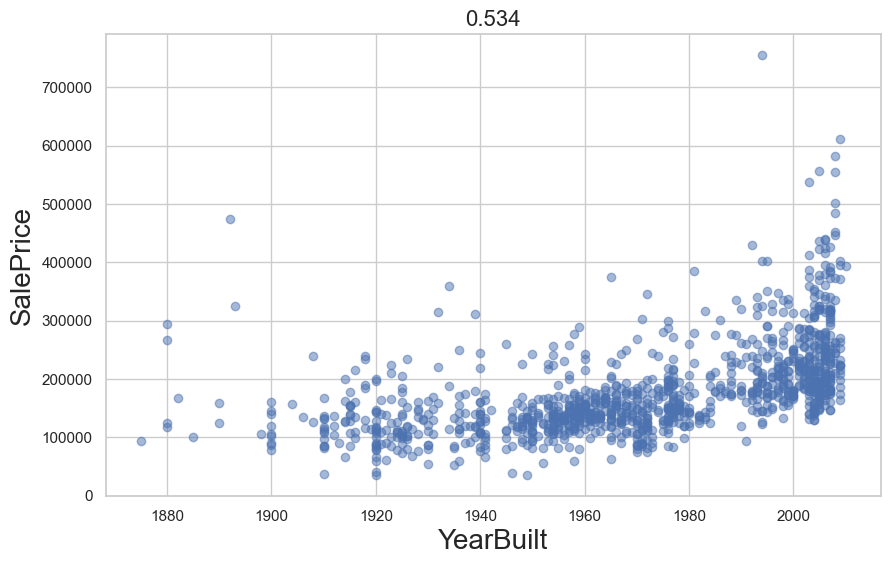

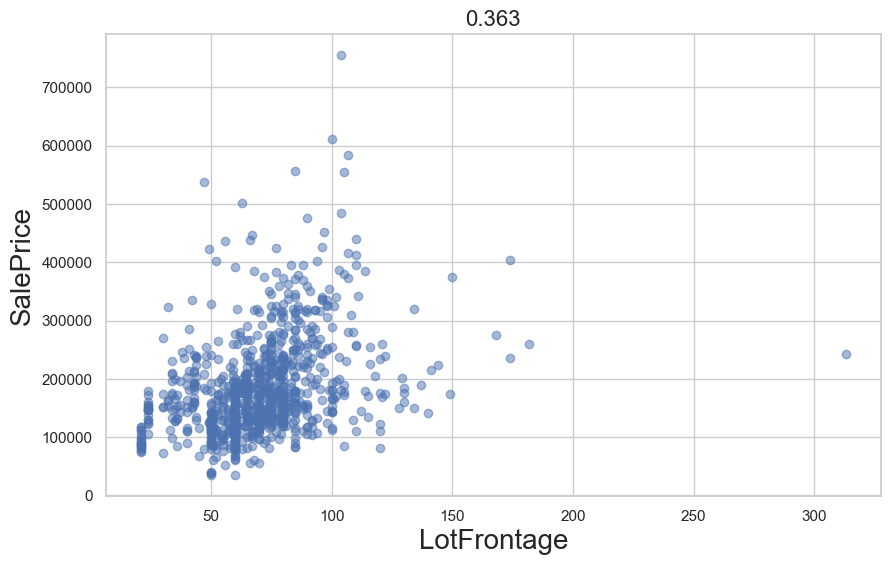

In [8]:
# base on df_training_correlation results
for index, row in df_training_correlation.iterrows():
    variable = row['Variable']
    correlation = row['Correlation with SalePrice']
    plt.figure(figsize=(10, 6))
    plt.scatter(df_training_set[variable], df_training_set['SalePrice'], alpha=0.5)  # plot scatter
    plt.title(correlation, fontsize=16) # correlation value as title
    plt.xlabel(variable, fontsize=20)  # x-axis label
    plt.ylabel('SalePrice', fontsize=20)  # y-axis label
    plt.grid(True)  # adding grid
    plt.show()
    print("\n" * 4)


In [9]:
# variables with more correlation
df_training_correlation.head(2)

,Variable,Correlation with SalePrice
0,OverallQual,0.794
1,1stFlrSF,0.616


# Función para entrenar modelo de regresión lineal

In [69]:
class LinearRegressionStep:
    def __init__(self, vect_x, vect_y, prediction, beta):
        self.vect_x = vect_x
        self.vect_y = vect_y
        self.prediction = prediction
        self.beta = beta

In [68]:
class LinearRegression:
    
    def __init__(self):
        self.steps = []
        self.errors = []
        
    def calculate_regression(self, vect_x, vect_y, epochs, print_error_every, learning_rate=0.01):
        
        vect_x = np.array(vect_x)
        vect_y = np.array(vect_y)
        
        if vect_x.size == 0 or vect_y.size == 0:
            raise ValueError('Input vectors cannot be empty.')
        
        if epochs <= 0 or learning_rate <= 0:
            raise ValueError('Epochs and learning rate must be positive.')
        
        if vect_x.shape[0] != vect_y.shape[0]:
            raise ValueError('Input vectors must have the same length.')
        
        observations = np.column_stack((vect_x, np.ones(vect_x.shape[0])))
        beta = np.zeros(2).reshape(2, 1)
        
        self.errors.clear()
        self.steps.clear()
        
        for epoch in range(epochs):
            # calculate predictions
            prediction = np.dot(observations, beta)
            # calculate error
            error = (1 / (2 * len(vect_y))) * np.sum((vect_y.reshape(-1, 1) - prediction) ** 2)
            # update error directly in self.errors
            self.errors.append(error) 
            # calculate gradient of the error
            gradient_errors = (1 / len(vect_y)) * np.dot(observations.T, (prediction - vect_y.reshape(-1, 1)))
            # update beta coefficients.
            beta -= learning_rate * gradient_errors
            # optionally print the error at specified intervals
            if print_error_every and (epoch + 1) % print_error_every == 0:
                print(f'epoch {epoch + 1}, error: {error}')
            # update step directly in self.steps
            self.steps.append(LinearRegressionStep(vect_x, vect_y, prediction, beta))
        return self.steps, self.errors
    
    def plotErrors(self, errors=None, show_values=False):
        if errors is None:
            errors = self.errors
        if not errors:
            raise ValueError('No errors to plot. The array is empty.')
        # plotting
        plt.figure(figsize=(10, 6))
        iterations = range(1, len(errors) + 1)
        plt.plot(iterations, errors, marker='o', linestyle='-', markersize=5)
        if show_values:
            for i, error in enumerate(errors, start=1):
                plt.text(i, error, f'{error:.2f}', ha='center', va='bottom')
        plt.title('Error Over Time', fontsize=16)
        plt.xlabel('Iteration', fontsize=20)
        plt.ylabel('Error', fontsize=20)
        plt.grid(True)
        plt.show()
        
    def plotSteps(self, steps=None, n=1):
        if steps is None:
            steps = self.steps
        if not steps:
            raise ValueError('No steps to plot. The array is empty.')
        # plotting
        plt.figure(figsize=(10, 6))
        vect_x = steps[0].vect_x
        vect_y = steps[0].vect_y
        plt.scatter(vect_x, vect_y, color='blue', label='Training data')
        for i, step in enumerate(steps):
            if (i + 1) % n == 0:
                plt.plot(vect_x, step.prediction, label=f'Iteration {i + 1}')
        plt.title('Model evolution', fontsize=16)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.legend()
        plt.grid(True)
        plt.show()    
        

epoch 5, error: 8.049340119502885
epoch 10, error: 2.301807934380465
epoch 15, error: 0.669819253107599
epoch 20, error: 0.20622763404721214
epoch 25, error: 0.07434558327012963
epoch 30, error: 0.03663956177008241
epoch 35, error: 0.025674323157651405
epoch 40, error: 0.02230509706528034
epoch 45, error: 0.021096658294601806
epoch 50, error: 0.02050588805195508
epoch 55, error: 0.020094627910798246
epoch 60, error: 0.019738416085706804
epoch 65, error: 0.01940184964332179
epoch 70, error: 0.019074810382981075
epoch 75, error: 0.01875435950635236
epoch 80, error: 0.018439597540996992
epoch 85, error: 0.01813020506702875
epoch 90, error: 0.01782602841476608
epoch 95, error: 0.01752696202731427
epoch 100, error: 0.01723291504587101
epoch 105, error: 0.01694380180594906
epoch 110, error: 0.0166595391221385
epoch 115, error: 0.016380045500407274
epoch 120, error: 0.016105240897906655


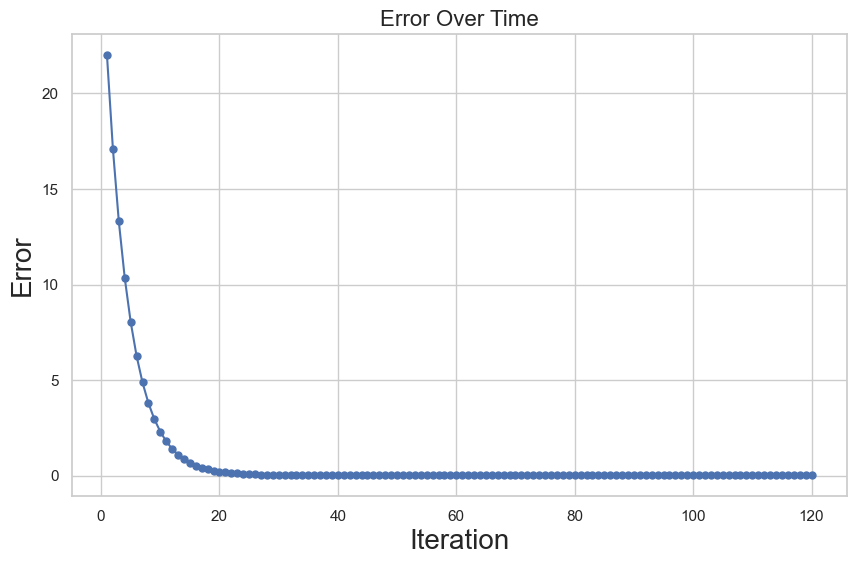

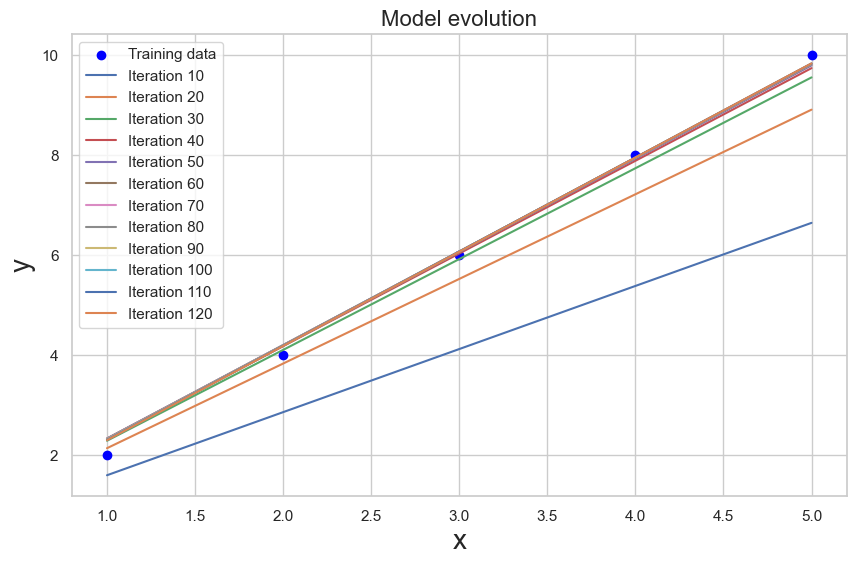

In [59]:
# debug
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 6, 8, 10])
model = LinearRegression()
steps, errors = model.calculate_regression(vect_x=x, vect_y=y, epochs=120, print_error_every=5, learning_rate=0.01)
model.plotErrors()
model.plotSteps(n=10)


# Entrenamiento con variables independientes

In [88]:
# traning dataset
df_SalesPrice = df_training_set['SalePrice'].values
df_OverallQual = df_training_set['OverallQual'].values
df_1stFlrSF = df_training_set['1stFlrSF'].values

## OverallQuall vs SalesPrice

epoch 5, error: 1693499585.3201776
epoch 10, error: 1394454395.5238411
epoch 15, error: 1391513812.4658077
epoch 20, error: 1390347591.754983
epoch 25, error: 1389197397.9684384
epoch 30, error: 1388052701.2844467
epoch 35, error: 1386913413.2789528
epoch 40, error: 1385779508.024703
epoch 45, error: 1384650960.087797
epoch 50, error: 1383527744.1567154
epoch 55, error: 1382409835.0395415
epoch 60, error: 1381297207.6633806
epoch 65, error: 1380189837.0738
epoch 70, error: 1379087698.434269
epoch 75, error: 1377990767.0255983
epoch 80, error: 1376899018.2453914
epoch 85, error: 1375812427.6074882
epoch 90, error: 1374730970.7414174
epoch 95, error: 1373654623.3918502
epoch 100, error: 1372583361.418056
epoch 105, error: 1371517160.7933614
epoch 110, error: 1370455997.6046095
epoch 115, error: 1369399848.0516264
epoch 120, error: 1368348688.4466858


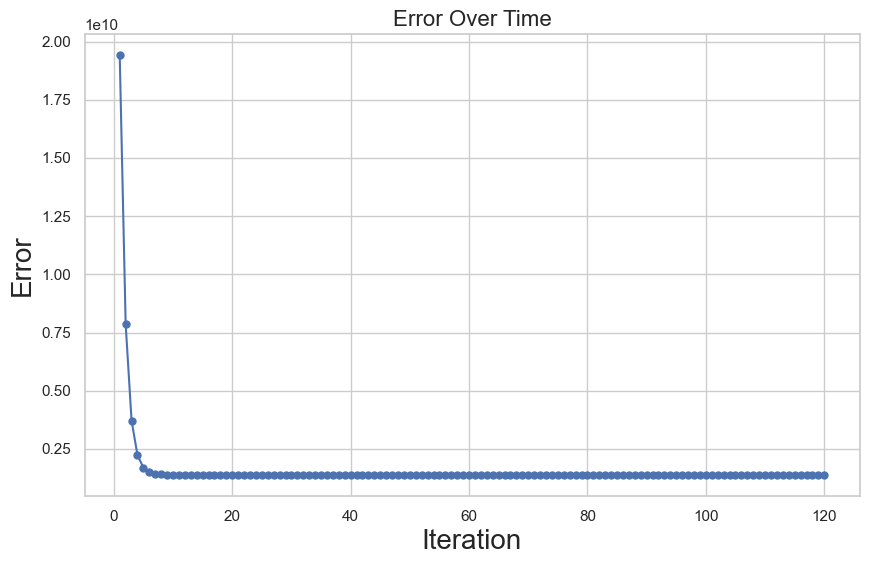

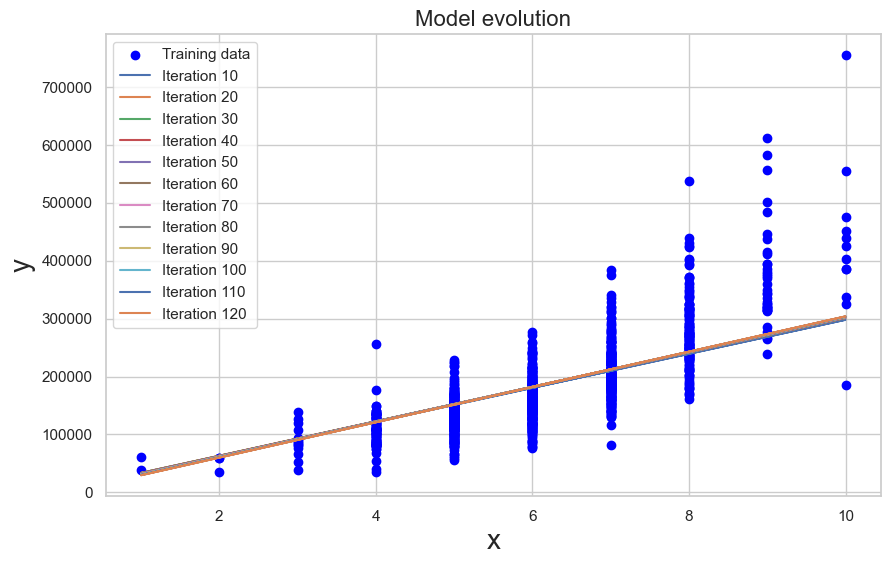

In [87]:
# OverallQuall vs SalesPrice
L_OverallQualSalesPriceModel = LinearRegression()
L_OverallQualSalesPriceModelSteps, L_OverallQualSalesPriceModelErrors = L_OverallQualSalesPriceModel.calculate_regression(vect_x=df_OverallQual, vect_y=df_SalesPrice, epochs=120, print_error_every=5, learning_rate=0.01)
L_OverallQualSalesPriceModel.plotErrors()
L_OverallQualSalesPriceModel.plotSteps(n=10)

## 1stFlrSF vs SalesPrice

epoch 5, error: 2014585618.3584678
epoch 10, error: 1968121172.4194336
epoch 15, error: 1968092988.619781
epoch 20, error: 1968092930.4870646
epoch 25, error: 1968092889.3896332
epoch 30, error: 1968092848.3025582
epoch 35, error: 1968092807.2155285
epoch 40, error: 1968092766.1285374
epoch 45, error: 1968092725.0415857
epoch 50, error: 1968092683.9546726
epoch 55, error: 1968092642.8677979
epoch 60, error: 1968092601.7809622
epoch 65, error: 1968092560.6941657
epoch 70, error: 1968092519.6074076
epoch 75, error: 1968092478.5206883
epoch 80, error: 1968092437.4340084
epoch 85, error: 1968092396.3473668
epoch 90, error: 1968092355.2607646
epoch 95, error: 1968092314.1742005
epoch 100, error: 1968092273.0876756
epoch 105, error: 1968092232.0011897
epoch 110, error: 1968092190.9147422
epoch 115, error: 1968092149.8283339
epoch 120, error: 1968092108.741965


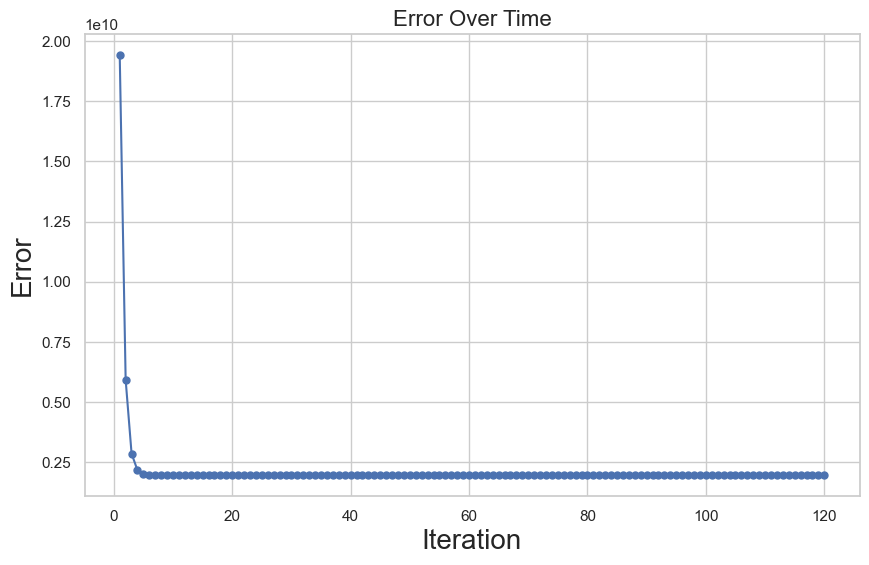

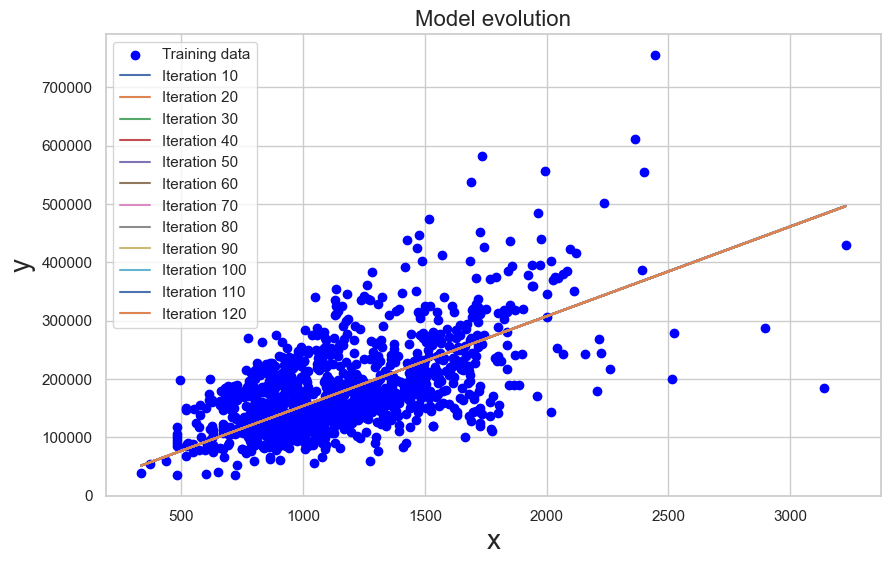

In [86]:
# 1stFlrSF vs SalesPrice
L_1stFlrSFSalesPriceModel = LinearRegression()
L_1stFlrSFSalesPriceModelSteps, L_1stFlrSFSalesPriceModelErrors = L_1stFlrSFSalesPriceModel.calculate_regression(vect_x=df_1stFlrSF, vect_y=df_SalesPrice, epochs=120, print_error_every=5, learning_rate=0.000001)
L_1stFlrSFSalesPriceModel.plotErrors()
L_1stFlrSFSalesPriceModel.plotSteps(n=10)

# Entrenamiento con Sklearn

In [100]:
# OverallQuall vs SalesPrice (SKL)
SKL_OverallQualSalesPriceModel = SKLinearRegression()
SKL_OverallQualSalesPriceModel.fit(df_OverallQual.reshape(-1, 1), df_SalesPrice)

LinearRegression()

In [101]:
# 1stFlrSF vs SalesPrice (SKL)
SKL_1stFlrSFSalesPriceModel = SKLinearRegression()
SKL_1stFlrSFSalesPriceModel.fit(df_1stFlrSF.reshape(-1, 1), df_SalesPrice)

LinearRegression()

# Predicción

In [115]:
# validation and test dataset
df_SalesPrice_validation = df_validation_and_test_set['SalePrice'].values
df_OverallQual_validation = df_validation_and_test_set['OverallQual'].values
df_1stFlrSF_validation = df_validation_and_test_set['1stFlrSF'].values

In [116]:
def predictionCalc(l_reg_model=None, skl_reg_model=None, vect_x=None):
    if l_reg_model is None:
        raise ValueError('No manual model. The object is null.')
    if skl_reg_model is None:
        raise ValueError('No sklearn model. The object is null.')
    if vect_x is None:
        raise ValueError('No independent variables. The array is empty.')
    
    # predictions from models & average (combination of the two predictions)
    l_predic = np.zeros(len(vect_x))
    skl_predict = np.zeros(len(vect_x))
    l_skl_predict_average = np.zeros(len(vect_x))
    
    # for manual
    last_step = l_reg_model.steps[-1]
    manual_beta = last_step.beta
    l_predic = (vect_x * manual_beta[0] + manual_beta[1]).flatten()
    
    # skl
    skl_predict = skl_reg_model.predict(vect_x.reshape(-1, 1)).flatten()

    # average
    l_skl_predict_average = (l_predic + skl_predict) / 2
    
    return l_predic, skl_predict, l_skl_predict_average
    

In [117]:
# OverallQual vs SalesPrice
l_predicQS, skl_predictQS, l_skl_predict_averageQS = predictionCalc(L_OverallQualSalesPriceModel, SKL_OverallQualSalesPriceModel, df_OverallQual_validation)

In [119]:
# 1stFlrSF vs SalesPrice
l_predic1S, skl_predict1S, l_skl_predict_average1S = predictionCalc(L_1stFlrSFSalesPriceModel, SKL_1stFlrSFSalesPriceModel, df_1stFlrSF_validation)

# Verificación

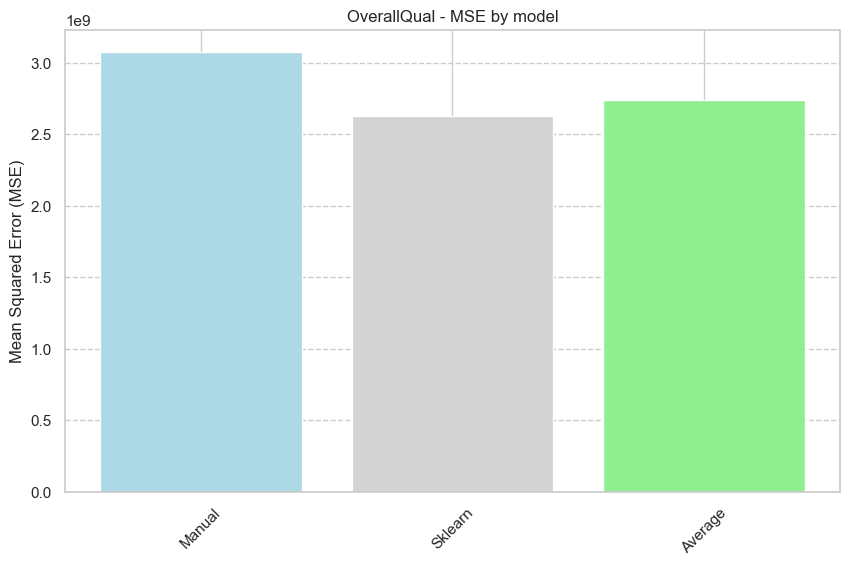

El modelo SKlearn sera el mejor para la variable OverallQual


In [128]:
# Mean Squared Error (MSE)

# OverallQual
mse_l_predicQS = mean_squared_error(df_SalesPrice_validation, l_predicQS)
mse_skl_predictQS = mean_squared_error(df_SalesPrice_validation, skl_predictQS)
mse_average_predictQS = mean_squared_error(df_SalesPrice_validation, l_skl_predict_averageQS)

overallQual_errors = [mse_l_predicQS, mse_skl_predictQS, mse_average_predictQS]
overallQual_models = ['Manual', 'Sklearn', 'Average']
plt.figure(figsize=(10, 6))
plt.bar(overallQual_models, overallQual_errors, color=['lightblue', 'lightgray', 'lightgreen'])
plt.title('OverallQual - MSE by model')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()
print('===============================================================')
print('El modelo SKlearn sera el mejor para la variable OverallQual')
print('===============================================================')

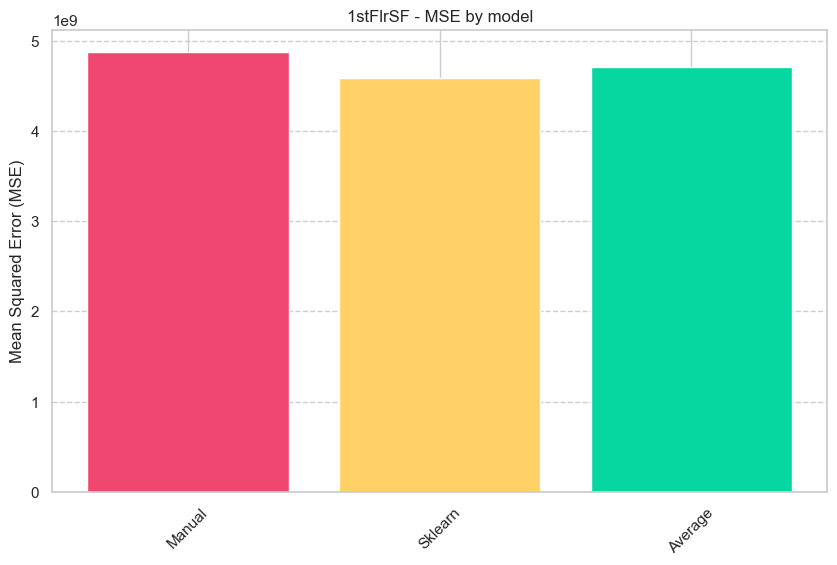

El modelo SKlearn sera el mejor para la variable 1stFlrSF


In [131]:
# Mean Squared Error (MSE)

# 1stFlrSF
mse_l_predic1S = mean_squared_error(df_SalesPrice_validation, l_predic1S)
mse_skl_predict1S = mean_squared_error(df_SalesPrice_validation, skl_predict1S)
mse_average_predict1S = mean_squared_error(df_SalesPrice_validation, l_skl_predict_average1S)

_1stFlrSF_errors = [mse_l_predic1S, mse_skl_predict1S, mse_average_predict1S]
_1stFlrSF_errors_models = ['Manual', 'Sklearn', 'Average']
plt.figure(figsize=(10, 6))
plt.bar(_1stFlrSF_errors_models, _1stFlrSF_errors, color=['#ef476f', '#ffd166', '#06d6a0'])
plt.title('1stFlrSF - MSE by model')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()
print('===============================================================')
print('El modelo SKlearn sera el mejor para la variable 1stFlrSF')
print('===============================================================')
